In [1]:
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
from PIL import Image
import cv2
import csv
import av
import json
from torchvision import datasets, transforms
from torch.utils.data import Dataset, DataLoader
import models

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


In [3]:
info_json_path = os.path.join(os.getcwd() + "/../Video processing" + os.sep + "video_small" + os.sep + "smaller_transition_times.json")
with open(info_json_path, 'r', encoding='utf-8') as file:
    info_json = json.load(file)

In [4]:
path_to_data = os.path.normpath(os.getcwd() + "/../Image processing" + os.sep + "video_proc/")

In [5]:
train_path = os.path.join(path_to_data, 'train')
val_path = os.path.join(path_to_data, 'val')

In [6]:
# List all files in the directory
image_path = train_path
files = os.listdir(image_path)

# Filter out only image files
image_files = [file for file in files if file.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.gif'))]

# If there are image files
if image_files:
    # Get the first image file
    first_image = image_files[0]
    
    # Open the image using Pillow
    with Image.open(os.path.join(image_path, first_image)) as img:
        # Get the size of the image
        width, height = img.size
        # Get the mode of the image
        mode = img.mode
        
        # Get the number of channels based on the mode
        channels = len(mode)
        print(f"The size of the first image '{first_image}' is {width}x{height} pixels.")
        print(f"The image mode is '{mode}' with {channels} channel(s).")
else:
    print("No image files found in the directory.")

The size of the first image '25 Best Trampoline Fail Nominees - FailArmy Hall of Fame (July 2017)18_00.jpg' is 240x240 pixels.
The image mode is 'L' with 1 channel(s).


In [27]:
filename = '25 best'
for i in range(3):
    s = str(i).zfill(2)
    print(filename + '_' + s + '.jpg')

25 best_00.jpg
25 best_01.jpg
25 best_02.jpg


In [7]:
from torchvision.io import read_image

class VideoImageDataset(Dataset):
    def __init__(self, img_dir, device, transform=None, mode='train'):
        self.img_dir = img_dir
        self.transform = transform
        self.mode = mode
        self.device = device
        self.data = self.load_data()
        

    def __len__(self):
        return len(self.data)
    
    def load_data(self):
        data = []
        for filename in info_json:
            if info_json[filename]['category'] != self.mode:
                continue

            csv_path = os.path.join(self.img_dir, filename + '_labels.csv')
            for i in range(25):
                num = str(i).zfill(2)
                img_path = os.path.join(self.img_dir, filename + '_' + num + '.jpg')
                data.append((img_path, csv_path, i))
        
        return data
            
    def __getitem__(self, idx):
        img_path, csv_path, id = self.data[idx]
        image = Image.open(img_path)

        with open(csv_path, 'r', encoding='utf-8') as file:
            csv_reader = csv.reader(file)
            
            row = next(csv_reader)
            label = 0
            # Access the i'th element from the row and parse it as an integer
            try:
                label = int(row[id])
            except IndexError:
                print(f"The index {id} is out of range.")
            except ValueError:
                print(f"The value at index {id} is not an integer.")
            
        if self.transform:
            image = self.transform(image)
        return image, label

In [17]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

In [66]:
train_dataset = VideoImageDataset(train_path, device=device, transform=transform, mode='train')
val_dataset = VideoImageDataset(val_path, device=device, transform=transform, mode='val')

In [8]:
# Possible data augmentation transforms
RN_transform = transforms.Compose([
    # Resize the image to (224, 224) and convert to RGB
    transforms.Resize((224, 224)),
    transforms.Grayscale(num_output_channels=3),  # Convert single-channel image to RGB
    # Random horizontal flip with probability 0.5
    transforms.RandomHorizontalFlip(p=0.5),
    # Random rotation between -10 and 10 degrees
    transforms.RandomRotation(degrees=(-10, 10)),
    # Random brightness adjustment
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    # Convert PIL image to tensor and normalize
    transforms.ToTensor(),
    # Normalize with mean and standard deviation of ImageNet dataset
    # transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [9]:
train_dataset = VideoImageDataset(train_path, device=device, transform=RN_transform, mode='train')
val_dataset = VideoImageDataset(val_path, device=device, transform=RN_transform, mode='val')

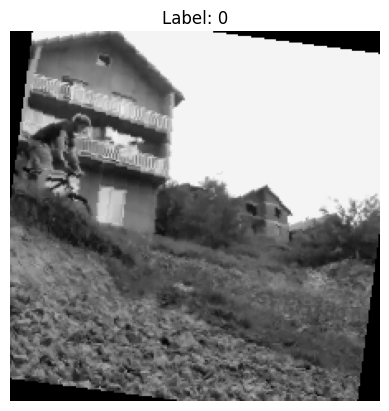

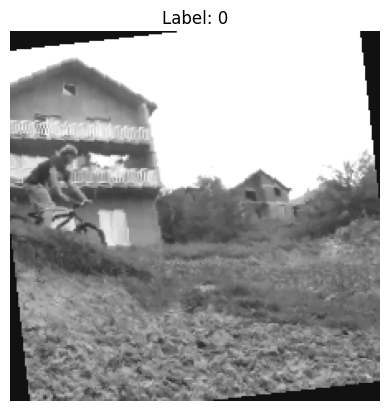

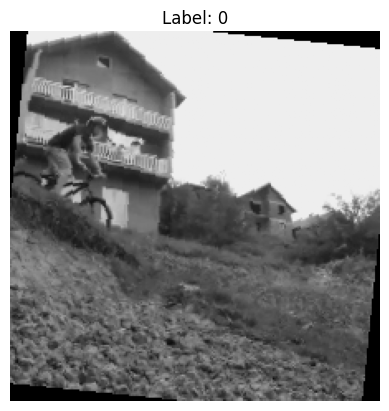

In [10]:
for i in range(3):
    img, label = val_dataset.__getitem__(i)
    img = img.permute(1, 2, 0).numpy()
    if label == None:
        print('exist None labels')
    plt.imshow(img, cmap='gray')
    plt.title(f'Label: {label}')
    plt.axis('off')
    plt.show()

In [11]:
batch_size = 50 
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)

In [14]:
for batch_idx, (images, labels) in enumerate(train_dataloader):
    # Access image-label tuple at a specific index
    index = 10  # Example index
    if batch_idx * train_dataloader.batch_size <= index < (batch_idx + 1) * train_dataloader.batch_size:
        image, label = images[index % train_dataloader.batch_size], labels[index % train_dataloader.batch_size]
        # Use image and label as needed
        print("Image shape:", image.shape)
        print("Label:", label)
        break  # Break the loop after accessing the desired tuplef

Image shape: torch.Size([3, 224, 224])
Label: tensor(0)


In [ ]:
from tqdm import tqdm

for images, labels in tqdm(train_dataloader):
    # Move data to GPU
    images = images.to(device)
    labels = labels.to(device)

for images, labels in tqdm(val_dataloader):
    # Move data to GPU
    images = images.to(device)
    labels = labels.to(device)

In [23]:
import torch
import pickle

# Save train and val datasets
with open('train_dataset.pkl', 'wb') as f:
    pickle.dump(train_dataset, f)

with open('val_dataset.pkl', 'wb') as f:
    pickle.dump(val_dataset, f)

# Save train and val dataloaders
with open('train_dataloader.pkl', 'wb') as f:
    pickle.dump(train_dataloader, f)

with open('val_dataloader.pkl', 'wb') as f:
    pickle.dump(val_dataloader, f)



In [ ]:
from models import NaiveCNN

# Initialize the model
test_model = NaiveCNN.NaiveCNN().to(device)

# Print the model architecture
print(test_model)

test_model.load_state_dict(torch.load('checkpoints/NaiveCNN.pth', map_location=device))


In [44]:
from models import ResNet34

model = ResNet34.ModResNet().to(device)


In [12]:
from models import ResNet50

model = ResNet50.ModResNet().to(device)
# print(model)

In [ ]:
for name, param in model.named_parameters():
    print(f'Layer: {name}, Requires Grad: {param.requires_grad}')

In [13]:
from tqdm import tqdm
train_target = []
val_target = []
for i in tqdm(range(train_dataset.__len__())):
    img, label = train_dataset.__getitem__(i)
    train_target.append(label)

for i in tqdm(range(val_dataset.__len__())):
    img, label = val_dataset.__getitem__(i)
    val_target.append(label)

100%|██████████| 6000/6000 [00:48<00:00, 124.63it/s]


In [ ]:
print(train_target)
print(val_target)

In [14]:
from sklearn.utils.class_weight import compute_class_weight

# Calculate class weights
class_weights = compute_class_weight('balanced', classes=np.unique(np.array([0, 1])), y=train_target)
class_weights = torch.tensor(class_weights, dtype=torch.float32).to(device)
print(class_weights)

tensor([0.7023, 1.7359], device='cuda:0')


In [14]:
class_weights = torch.tensor([0.7023, 1.7359], dtype=torch.float32).to(device)

In [79]:
from tqdm import tqdm
from sklearn.metrics import f1_score
import torch.optim as optim
import torch.nn as nn
# Define device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# NaiveCNN params
criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer = optim.SGD(model.parameters(), lr=0.02, weight_decay=0.001)

In [12]:
from tqdm import tqdm
from sklearn.metrics import f1_score
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.nn as nn
# Define device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# RN34 Params
criterion = nn.CrossEntropyLoss(weight=class_weights)

# criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.003, weight_decay=1e-4)
scheduler = lr_scheduler.StepLR(optimizer, step_size=6, gamma=0.2)


In [16]:
from tqdm import tqdm
from sklearn.metrics import f1_score
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.nn as nn

# Define device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# RN50 Params
criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer = optim.SGD(model.parameters(), lr=0.1, weight_decay=1e-5)
scheduler = lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

In [20]:
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []
train_f1_scores = []
val_f1_scores = []

In [21]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
def train_model(file_dir, model_name, num_epochs=20):
    if not os.path.exists("checkpoints/" + file_dir):
        os.makedirs("checkpoints/" + file_dir)
    if not os.path.exists(file_dir):
        os.makedirs(file_dir)
    
    min_loss = 1e3
    max_f1 = 0
    for epoch in range(num_epochs):
        model.train()  # Set the model to training mode
        running_loss = 0.0
        correct = 0
        total = 0
        train_preds = []
        train_targets = []
        # Iterate over the training dataset
        for images, labels in tqdm(train_dataloader, desc=f'Training Epoch {epoch+1}/{num_epochs}', unit='batch'):
            # Move images and labels to the GPU
            images, labels = images.to(device), labels.to(device)

            # Zero the parameter gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            # Backward pass and optimization
            loss.backward()
            optimizer.step()

            # Compute training accuracy
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            train_preds.extend(predicted.cpu().numpy())
            train_targets.extend(labels.cpu().numpy())
            # Update running loss
            running_loss += loss.item()

        # Compute training accuracy and loss for the epoch
        train_epoch_loss = running_loss / len(train_dataloader)
        train_epoch_accuracy = 100 * correct / total

        # Store training loss and accuracy
        train_losses.append(train_epoch_loss)
        train_accuracies.append(train_epoch_accuracy)
        train_f1 = f1_score(train_targets, train_preds, average='macro')
        train_f1_scores.append(train_f1)
        # Validation loop
        model.eval()  # Set the model to evaluation mode
        val_correct = 0
        val_total = 0
        val_running_loss = 0.0
        val_preds = []
        val_targets = []

        with torch.no_grad():
            for val_images, val_labels in tqdm(val_dataloader, desc=f'Validation Epoch {epoch+1}/{num_epochs}', unit='batch'):
                val_images, val_labels = val_images.to(device), val_labels.to(device)
                val_outputs = model(val_images)
                val_loss = criterion(val_outputs, val_labels)
                _, val_predicted = torch.max(val_outputs, 1)
                val_total += val_labels.size(0)
                val_correct += (val_predicted == val_labels).sum().item()
                val_running_loss += val_loss.item()

                val_preds.extend(val_predicted.cpu().numpy())
                val_targets.extend(val_labels.cpu().numpy())

        # Compute validation loss, accuracy, and F1 score for the epoch
        val_epoch_loss = val_running_loss / len(val_dataloader)
        val_epoch_accuracy = 100 * val_correct / val_total
        val_f1 = f1_score(val_targets, val_preds, average='macro')
        
        # Store validation loss, accuracy, and F1 score
        val_losses.append(val_epoch_loss)
        val_accuracies.append(val_epoch_accuracy)
        val_f1_scores.append(val_f1)

        print(f'Training Epoch [{epoch+1}/{num_epochs}], Loss: {train_epoch_loss:.4f}, F1 Score: {train_f1:.4f}')
        print(f'Validation Epoch [{epoch+1}/{num_epochs}], Loss: {val_epoch_loss:.4f}, F1 Score: {val_f1:.4f}')

        # Draw conf mat routine
        cm = confusion_matrix(val_targets, val_preds)
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['0', '1'], yticklabels=['0', '1'])
        plt.xlabel('Predicted')
        plt.ylabel('True')
        plt.title('Confusion Matrix')
        # Add F1 score as text to the plot
        f1 = f1_score(val_targets, val_preds, average='macro')
        plt.text(0.5, -0.1, f'F1 score: {f1:.2f}', horizontalalignment='center', verticalalignment='center', transform=plt.gca().transAxes)
        plt.savefig(file_dir + f"/confmat_{epoch+1}.png")
        plt.close()


        # Save the trained model to a file
        file_path = "checkpoints/" + file_dir + "/" + model_name + f"ep_{epoch + 1}" + ".pth"
        if val_epoch_loss < min_loss:
            torch.save(model.state_dict(), file_path)
            min_loss = val_epoch_loss
            max_f1 = max(max_f1, val_f1)
            continue
        if val_f1 > max_f1:
            torch.save(model.state_dict(), file_path)
            max_f1 = val_f1
            min_loss = min(min_loss, val_epoch_loss)
            continue
        min_loss = min(min_loss, val_epoch_loss)
        max_f1 = max(max_f1, val_f1)
    file_path = "checkpoints/" + file_dir + "/" + model_name + f"ep_{num_epochs}" + ".pth"
    torch.save(model.state_dict(), file_path)


In [23]:
trial_name = "trial3"
trial_dir = "checkpoints/trial3"

In [24]:
train_model(trial_name, "RN50", 50)

Validation Epoch 1/50: 100%|██████████| 120/120 [01:42<00:00,  1.17batch/s]


Training Epoch [1/50], Loss: 0.6436, F1 Score: 0.5859
Validation Epoch [1/50], Loss: 0.6397, F1 Score: 0.5581


Validation Epoch 2/50: 100%|██████████| 120/120 [00:28<00:00,  4.25batch/s]


Training Epoch [2/50], Loss: 0.4558, F1 Score: 0.7531
Validation Epoch [2/50], Loss: 0.6712, F1 Score: 0.6136


Validation Epoch 3/50: 100%|██████████| 120/120 [00:27<00:00,  4.42batch/s]


Training Epoch [3/50], Loss: 0.3260, F1 Score: 0.8346
Validation Epoch [3/50], Loss: 0.7517, F1 Score: 0.6683


Validation Epoch 4/50: 100%|██████████| 120/120 [00:27<00:00,  4.30batch/s]


Training Epoch [4/50], Loss: 0.2481, F1 Score: 0.8787
Validation Epoch [4/50], Loss: 0.8283, F1 Score: 0.6536


Validation Epoch 5/50: 100%|██████████| 120/120 [00:27<00:00,  4.31batch/s]


Training Epoch [5/50], Loss: 0.2055, F1 Score: 0.9001
Validation Epoch [5/50], Loss: 0.8682, F1 Score: 0.6709


Validation Epoch 6/50: 100%|██████████| 120/120 [00:27<00:00,  4.39batch/s]


Training Epoch [6/50], Loss: 0.1734, F1 Score: 0.9181
Validation Epoch [6/50], Loss: 0.9801, F1 Score: 0.6705


Validation Epoch 7/50: 100%|██████████| 120/120 [00:28<00:00,  4.28batch/s]


Training Epoch [7/50], Loss: 0.1422, F1 Score: 0.9341
Validation Epoch [7/50], Loss: 1.2946, F1 Score: 0.6650


Validation Epoch 8/50: 100%|██████████| 120/120 [00:28<00:00,  4.28batch/s]


Training Epoch [8/50], Loss: 0.1259, F1 Score: 0.9426
Validation Epoch [8/50], Loss: 1.0891, F1 Score: 0.6692


Validation Epoch 9/50: 100%|██████████| 120/120 [00:28<00:00,  4.27batch/s]


Training Epoch [9/50], Loss: 0.1196, F1 Score: 0.9462
Validation Epoch [9/50], Loss: 1.0391, F1 Score: 0.6263


Validation Epoch 10/50: 100%|██████████| 120/120 [00:27<00:00,  4.33batch/s]


Training Epoch [10/50], Loss: 0.1038, F1 Score: 0.9535
Validation Epoch [10/50], Loss: 1.2506, F1 Score: 0.6613


Validation Epoch 11/50: 100%|██████████| 120/120 [00:28<00:00,  4.25batch/s]


Training Epoch [11/50], Loss: 0.0907, F1 Score: 0.9587
Validation Epoch [11/50], Loss: 1.2519, F1 Score: 0.6633


Validation Epoch 12/50: 100%|██████████| 120/120 [00:27<00:00,  4.30batch/s]


Training Epoch [12/50], Loss: 0.0843, F1 Score: 0.9612
Validation Epoch [12/50], Loss: 1.2402, F1 Score: 0.6543


Validation Epoch 13/50: 100%|██████████| 120/120 [00:27<00:00,  4.40batch/s]


Training Epoch [13/50], Loss: 0.0742, F1 Score: 0.9665
Validation Epoch [13/50], Loss: 1.3842, F1 Score: 0.6585


Validation Epoch 14/50: 100%|██████████| 120/120 [00:27<00:00,  4.37batch/s]


Training Epoch [14/50], Loss: 0.0709, F1 Score: 0.9667
Validation Epoch [14/50], Loss: 1.5207, F1 Score: 0.6830


Validation Epoch 15/50: 100%|██████████| 120/120 [00:28<00:00,  4.21batch/s]


Training Epoch [15/50], Loss: 0.0662, F1 Score: 0.9699
Validation Epoch [15/50], Loss: 1.2458, F1 Score: 0.6501


Validation Epoch 16/50: 100%|██████████| 120/120 [00:27<00:00,  4.30batch/s]


Training Epoch [16/50], Loss: 0.0651, F1 Score: 0.9705
Validation Epoch [16/50], Loss: 1.2329, F1 Score: 0.6763


Validation Epoch 17/50: 100%|██████████| 120/120 [00:27<00:00,  4.30batch/s]


Training Epoch [17/50], Loss: 0.0606, F1 Score: 0.9731
Validation Epoch [17/50], Loss: 1.2732, F1 Score: 0.6826


Validation Epoch 18/50: 100%|██████████| 120/120 [00:27<00:00,  4.39batch/s]


Training Epoch [18/50], Loss: 0.0529, F1 Score: 0.9773
Validation Epoch [18/50], Loss: 1.4538, F1 Score: 0.6795


Validation Epoch 19/50: 100%|██████████| 120/120 [00:28<00:00,  4.28batch/s]


Training Epoch [19/50], Loss: 0.0522, F1 Score: 0.9768
Validation Epoch [19/50], Loss: 1.3655, F1 Score: 0.6439


Validation Epoch 20/50: 100%|██████████| 120/120 [00:28<00:00,  4.27batch/s]


Training Epoch [20/50], Loss: 0.0507, F1 Score: 0.9761
Validation Epoch [20/50], Loss: 1.3650, F1 Score: 0.6385


Validation Epoch 21/50: 100%|██████████| 120/120 [00:27<00:00,  4.38batch/s]


Training Epoch [21/50], Loss: 0.0467, F1 Score: 0.9795
Validation Epoch [21/50], Loss: 1.5512, F1 Score: 0.6866


Validation Epoch 22/50: 100%|██████████| 120/120 [00:28<00:00,  4.26batch/s]


Training Epoch [22/50], Loss: 0.0437, F1 Score: 0.9810
Validation Epoch [22/50], Loss: 1.6051, F1 Score: 0.6541


Validation Epoch 23/50: 100%|██████████| 120/120 [00:27<00:00,  4.32batch/s]


Training Epoch [23/50], Loss: 0.0376, F1 Score: 0.9824
Validation Epoch [23/50], Loss: 1.5866, F1 Score: 0.6493


Validation Epoch 24/50: 100%|██████████| 120/120 [00:43<00:00,  2.77batch/s]


Training Epoch [24/50], Loss: 0.0417, F1 Score: 0.9819
Validation Epoch [24/50], Loss: 1.5988, F1 Score: 0.6744


Validation Epoch 25/50: 100%|██████████| 120/120 [00:28<00:00,  4.19batch/s]


Training Epoch [25/50], Loss: 0.0343, F1 Score: 0.9848
Validation Epoch [25/50], Loss: 1.6335, F1 Score: 0.6742


Validation Epoch 26/50: 100%|██████████| 120/120 [00:27<00:00,  4.41batch/s]


Training Epoch [26/50], Loss: 0.0411, F1 Score: 0.9832
Validation Epoch [26/50], Loss: 1.4643, F1 Score: 0.6757


Validation Epoch 27/50: 100%|██████████| 120/120 [00:27<00:00,  4.34batch/s]


Training Epoch [27/50], Loss: 0.0343, F1 Score: 0.9851
Validation Epoch [27/50], Loss: 1.6360, F1 Score: 0.6683


Validation Epoch 28/50: 100%|██████████| 120/120 [00:34<00:00,  3.48batch/s]


Training Epoch [28/50], Loss: 0.0358, F1 Score: 0.9853
Validation Epoch [28/50], Loss: 1.5645, F1 Score: 0.6702


Validation Epoch 29/50: 100%|██████████| 120/120 [00:34<00:00,  3.51batch/s]


Training Epoch [29/50], Loss: 0.0319, F1 Score: 0.9862
Validation Epoch [29/50], Loss: 1.5172, F1 Score: 0.6564


Validation Epoch 30/50: 100%|██████████| 120/120 [00:31<00:00,  3.79batch/s]


Training Epoch [30/50], Loss: 0.0300, F1 Score: 0.9872
Validation Epoch [30/50], Loss: 1.7205, F1 Score: 0.6769


Validation Epoch 31/50: 100%|██████████| 120/120 [00:35<00:00,  3.36batch/s]


Training Epoch [31/50], Loss: 0.0290, F1 Score: 0.9871
Validation Epoch [31/50], Loss: 1.6204, F1 Score: 0.6868


Validation Epoch 32/50: 100%|██████████| 120/120 [00:36<00:00,  3.31batch/s]


Training Epoch [32/50], Loss: 0.0303, F1 Score: 0.9878
Validation Epoch [32/50], Loss: 1.6327, F1 Score: 0.6755


Validation Epoch 33/50: 100%|██████████| 120/120 [00:27<00:00,  4.34batch/s]


Training Epoch [33/50], Loss: 0.0269, F1 Score: 0.9887
Validation Epoch [33/50], Loss: 1.5721, F1 Score: 0.6431


Validation Epoch 34/50: 100%|██████████| 120/120 [00:27<00:00,  4.33batch/s]


Training Epoch [34/50], Loss: 0.0285, F1 Score: 0.9880
Validation Epoch [34/50], Loss: 1.5719, F1 Score: 0.6191


Validation Epoch 35/50: 100%|██████████| 120/120 [00:28<00:00,  4.22batch/s]


Training Epoch [35/50], Loss: 0.0291, F1 Score: 0.9873
Validation Epoch [35/50], Loss: 1.6447, F1 Score: 0.6735


Validation Epoch 36/50: 100%|██████████| 120/120 [00:27<00:00,  4.36batch/s]


Training Epoch [36/50], Loss: 0.0258, F1 Score: 0.9886
Validation Epoch [36/50], Loss: 1.7374, F1 Score: 0.6493


Validation Epoch 37/50: 100%|██████████| 120/120 [00:27<00:00,  4.32batch/s]


Training Epoch [37/50], Loss: 0.0260, F1 Score: 0.9885
Validation Epoch [37/50], Loss: 1.9011, F1 Score: 0.6699


Validation Epoch 38/50: 100%|██████████| 120/120 [00:27<00:00,  4.36batch/s]


Training Epoch [38/50], Loss: 0.0273, F1 Score: 0.9881
Validation Epoch [38/50], Loss: 1.7058, F1 Score: 0.6653


Validation Epoch 39/50: 100%|██████████| 120/120 [00:28<00:00,  4.27batch/s]


Training Epoch [39/50], Loss: 0.0226, F1 Score: 0.9903
Validation Epoch [39/50], Loss: 1.9157, F1 Score: 0.6875


Validation Epoch 40/50: 100%|██████████| 120/120 [00:27<00:00,  4.35batch/s]


Training Epoch [40/50], Loss: 0.0237, F1 Score: 0.9894
Validation Epoch [40/50], Loss: 1.6926, F1 Score: 0.6643


Validation Epoch 41/50: 100%|██████████| 120/120 [00:27<00:00,  4.29batch/s]


Training Epoch [41/50], Loss: 0.0206, F1 Score: 0.9912
Validation Epoch [41/50], Loss: 1.7879, F1 Score: 0.6672


Validation Epoch 42/50: 100%|██████████| 120/120 [00:28<00:00,  4.25batch/s]


Training Epoch [42/50], Loss: 0.0236, F1 Score: 0.9899
Validation Epoch [42/50], Loss: 1.8473, F1 Score: 0.6683


Validation Epoch 43/50: 100%|██████████| 120/120 [00:28<00:00,  4.25batch/s]


Training Epoch [43/50], Loss: 0.0225, F1 Score: 0.9904
Validation Epoch [43/50], Loss: 1.8067, F1 Score: 0.6622


Validation Epoch 44/50: 100%|██████████| 120/120 [00:29<00:00,  4.06batch/s]


Training Epoch [44/50], Loss: 0.0194, F1 Score: 0.9914
Validation Epoch [44/50], Loss: 1.8876, F1 Score: 0.6859


Validation Epoch 45/50: 100%|██████████| 120/120 [00:27<00:00,  4.32batch/s]


Training Epoch [45/50], Loss: 0.0193, F1 Score: 0.9914
Validation Epoch [45/50], Loss: 1.9489, F1 Score: 0.6745


Validation Epoch 46/50: 100%|██████████| 120/120 [00:33<00:00,  3.54batch/s]


Training Epoch [46/50], Loss: 0.0200, F1 Score: 0.9913
Validation Epoch [46/50], Loss: 2.0582, F1 Score: 0.6639


Validation Epoch 47/50: 100%|██████████| 120/120 [01:45<00:00,  1.14batch/s]


Training Epoch [47/50], Loss: 0.0170, F1 Score: 0.9930
Validation Epoch [47/50], Loss: 2.0687, F1 Score: 0.6786


Validation Epoch 48/50: 100%|██████████| 120/120 [00:28<00:00,  4.24batch/s]


Training Epoch [48/50], Loss: 0.0195, F1 Score: 0.9918
Validation Epoch [48/50], Loss: 1.7946, F1 Score: 0.6758


Validation Epoch 49/50: 100%|██████████| 120/120 [00:28<00:00,  4.26batch/s]


Training Epoch [49/50], Loss: 0.0201, F1 Score: 0.9913
Validation Epoch [49/50], Loss: 1.9977, F1 Score: 0.6783


Validation Epoch 50/50: 100%|██████████| 120/120 [00:27<00:00,  4.33batch/s]


Training Epoch [50/50], Loss: 0.0202, F1 Score: 0.9911
Validation Epoch [50/50], Loss: 1.7331, F1 Score: 0.6871


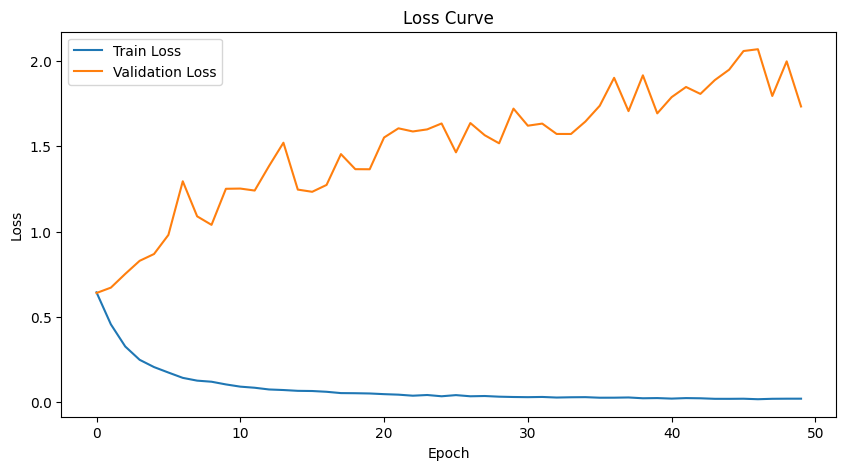

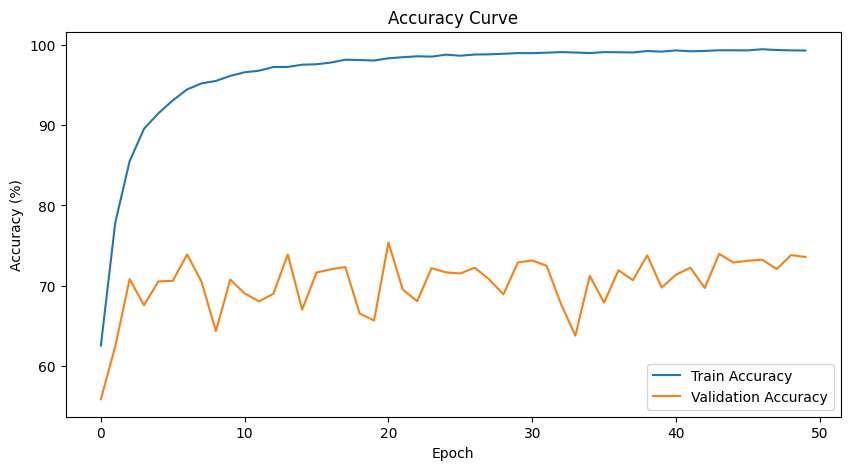

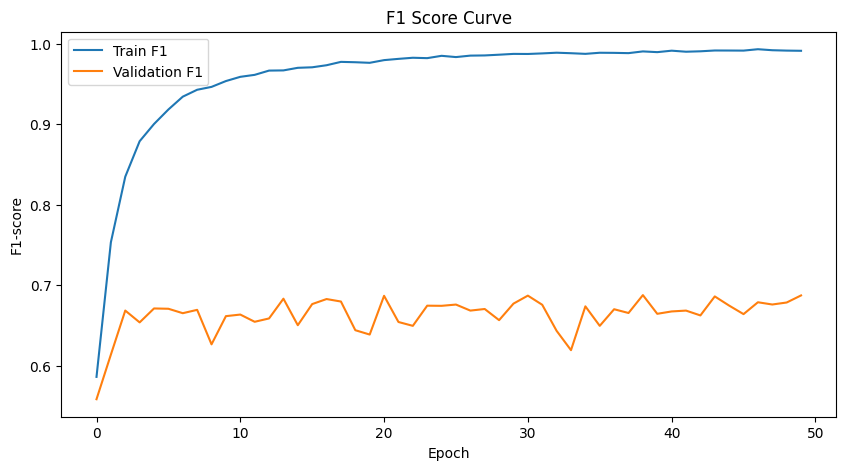

100%|██████████| 120/120 [00:28<00:00,  4.15it/s]


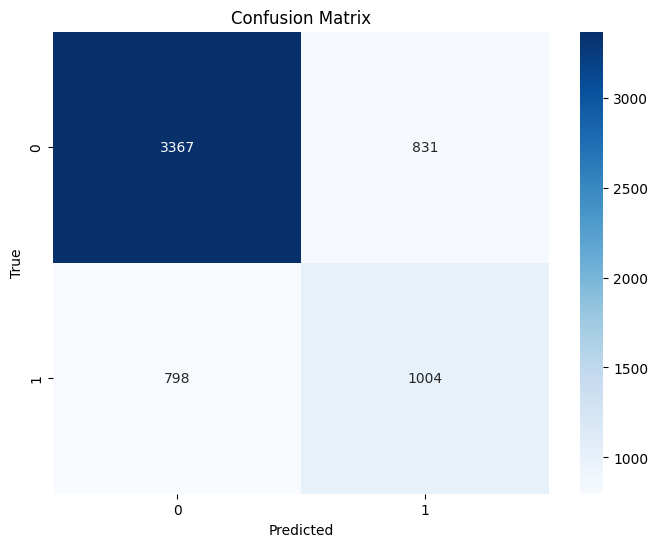

In [25]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Plot Loss Curve
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Curve')
plt.legend()
plt.show()

# Plot Accuracy Curve
plt.figure(figsize=(10, 5))
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy Curve')
plt.legend()
plt.show()

# Plot Accuracy Curve
plt.figure(figsize=(10, 5))
plt.plot(train_f1_scores, label='Train F1')
plt.plot(val_f1_scores, label='Validation F1')
plt.xlabel('Epoch')
plt.ylabel('F1-score')
plt.title('F1 Score Curve')
plt.legend()
plt.show()

# Plot Confusion Matrix
model.eval()  # Ensure model is in evaluation mode
val_preds = []
val_targets = []

with torch.no_grad():
    for val_images, val_labels in tqdm(val_dataloader):
        val_images, val_labels = val_images.to(device), val_labels.to(device)
        val_outputs = model(val_images)
        _, val_predicted = torch.max(val_outputs, 1)
        val_preds.extend(val_predicted.cpu().numpy())
        val_targets.extend(val_labels.cpu().numpy())

cm = confusion_matrix(val_targets, val_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['0', '1'], yticklabels=['0', '1'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


In [27]:
val_f1 = f1_score(val_targets, val_preds, average='macro')
print(val_f1)

0.6786584110306106


In [28]:
out_dataset = VideoImageDataset(val_path, device=device, transform=RN_transform, mode='val')
batch_size = 25
out_dataloader = DataLoader(out_dataset, batch_size=batch_size, shuffle=False)

In [34]:
def filter_checkpoints(checkpoint_dir, loss_list, f1_score_list):
    # Find the epoch with the lowest loss
    min_loss_epoch = loss_list.index(min(loss_list))
    # Find the epoch with the highest F1 score
    max_f1_score_epoch = f1_score_list.index(max(f1_score_list))

    # Keep the checkpoints with the lowest loss and highest F1 score
    checkpoints_to_keep = [min_loss_epoch + 1, max_f1_score_epoch + 1, len(loss_list)]

    # Remove other checkpoints
    for filename in os.listdir(checkpoint_dir):
        if filename.endswith(".pth"):
            _filename = filename[:-4]
            print(_filename)
            epoch = int(_filename.split("_")[1])
            print(epoch)
            if epoch not in checkpoints_to_keep:
                os.remove(os.path.join(checkpoint_dir, filename))
                print(f"Removed checkpoint '{filename}'")

In [32]:
def output_labels(model, checkpoint_dir):
    for filename in os.listdir(checkpoint_dir):
        if filename.endswith(".pth"):
            _filename = filename[:-4]
            print(_filename)
            epoch = int(_filename.split("_")[1])
            model.load_state_dict(torch.load(checkpoint_dir + os.sep + filename, map_location=device))
            
            model.eval()  # Ensure model is in evaluation mode
            val_preds = []
            val_targets = []

            with torch.no_grad():
                for val_images, val_labels in tqdm(out_dataloader):
                    val_images, val_labels = val_images.to(device), val_labels.to(device)
                    val_outputs = model(val_images)
                    _, val_predicted = torch.max(val_outputs, 1)
                    val_preds.extend(val_predicted.cpu().numpy())
                    val_targets.extend(val_labels.cpu().numpy())
            
            output_label = checkpoint_dir + f"/labels_{epoch}.csv"
            label_data = list(zip(val_targets, val_preds))
            
            # Draw conf mat routine
            cm = confusion_matrix(val_targets, val_preds)
            plt.figure(figsize=(8, 6))
            sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['0', '1'], yticklabels=['0', '1'])
            plt.xlabel('Predicted')
            plt.ylabel('True')
            plt.title('Confusion Matrix')
            # Add F1 score as text to the plot
            f1 = f1_score(val_targets, val_preds, average='macro')
            plt.text(0.5, -0.1, f'F1 score: {f1:.2f}', horizontalalignment='center', verticalalignment='center', transform=plt.gca().transAxes)
            plt.savefig(checkpoint_dir + f"/confmat_{epoch}.png")
            
            with open(output_label, mode='w', newline='', encoding='utf-8') as file:
                writer = csv.writer(file)
                writer.writerow(['target', 'predicted'])
                writer.writerows(label_data)
            print(f"CSV file '{output_label}' has been created with the labels and headers.")

In [35]:
filter_checkpoints(trial_dir, val_losses, val_f1_scores)

RN50ep_1
1
RN50ep_14
14
Removed checkpoint 'RN50ep_14.pth'
RN50ep_2
2
Removed checkpoint 'RN50ep_2.pth'
RN50ep_21
21
Removed checkpoint 'RN50ep_21.pth'
RN50ep_3
3
Removed checkpoint 'RN50ep_3.pth'
RN50ep_31
31
Removed checkpoint 'RN50ep_31.pth'
RN50ep_39
39
RN50ep_5
5
Removed checkpoint 'RN50ep_5.pth'
RN50ep_50
50


RN50ep_1


100%|██████████| 240/240 [00:29<00:00,  8.15it/s]


CSV file 'checkpoints/trial3/labels_1.csv' has been created with the labels and headers.
RN50ep_39


100%|██████████| 240/240 [00:29<00:00,  8.01it/s]


CSV file 'checkpoints/trial3/labels_39.csv' has been created with the labels and headers.
RN50ep_50


100%|██████████| 240/240 [00:29<00:00,  8.04it/s]


CSV file 'checkpoints/trial3/labels_50.csv' has been created with the labels and headers.


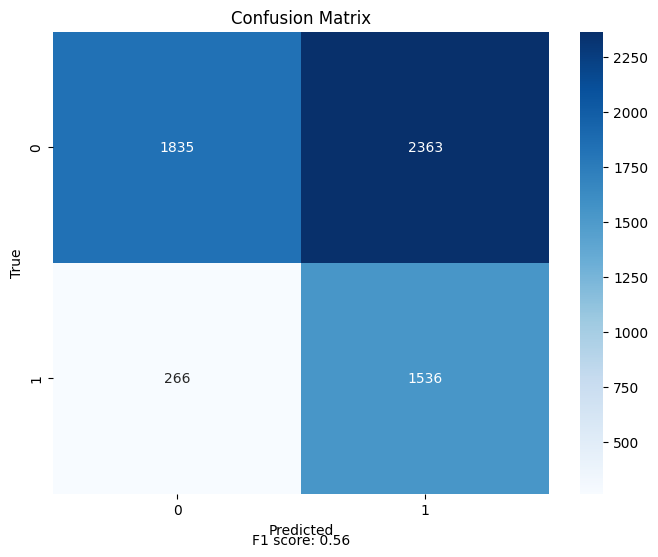

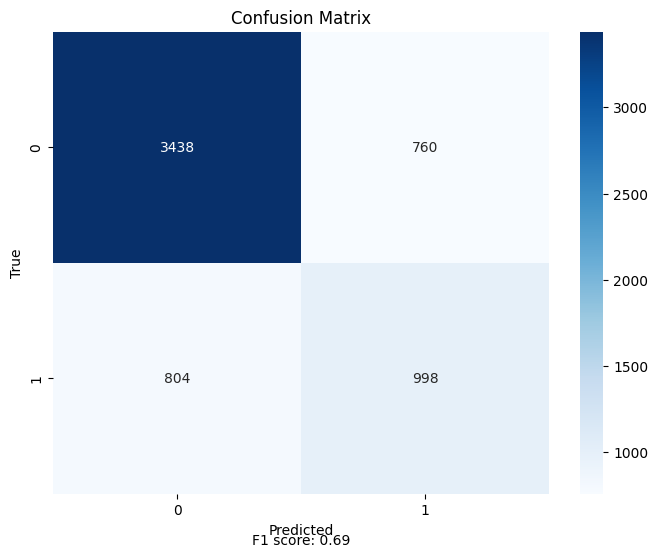

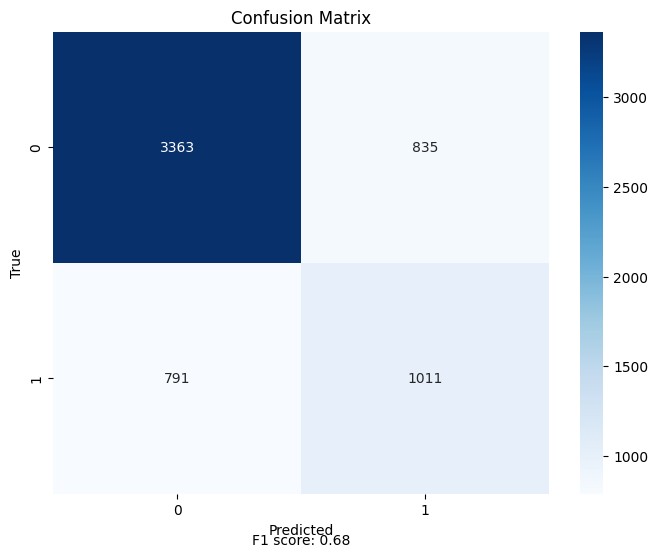

In [36]:
output_labels(model, trial_dir)

In [37]:
model.load_state_dict(torch.load('checkpoints/trial3/RN50ep_39.pth', map_location=device))

<All keys matched successfully>

100%|██████████| 240/240 [00:29<00:00,  8.22it/s]


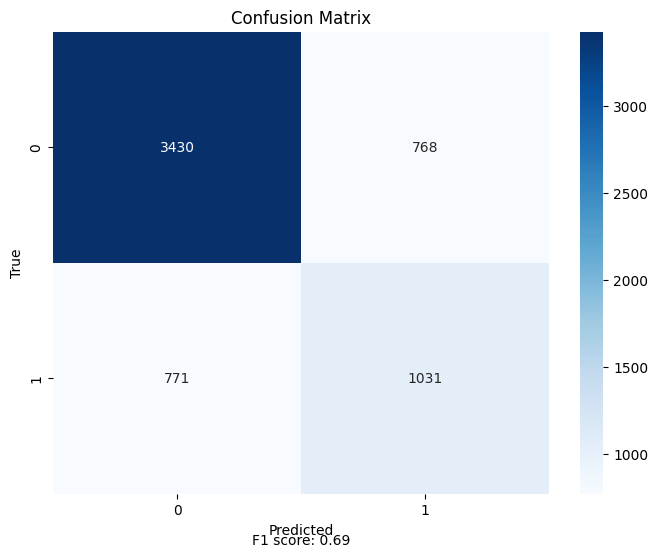

CSV file 'checkpoints/trial3/labels_val.csv' has been created with the labels and headers.


In [38]:
model.eval()  # Ensure model is in evaluation mode
val_preds = []
val_targets = []

with torch.no_grad():
    for val_images, val_labels in tqdm(out_dataloader):
        val_images, val_labels = val_images.to(device), val_labels.to(device)
        val_outputs = model(val_images)
        _, val_predicted = torch.max(val_outputs, 1)
        val_preds.extend(val_predicted.cpu().numpy())
        val_targets.extend(val_labels.cpu().numpy())

output_label = "checkpoints/trial3/labels_val.csv"
label_data = list(zip(val_targets, val_preds))

# Draw conf mat routine
cm = confusion_matrix(val_targets, val_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['0', '1'], yticklabels=['0', '1'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
# Add F1 score as text to the plot
f1 = f1_score(val_targets, val_preds, average='macro')
plt.text(0.5, -0.1, f'F1 score: {f1:.2f}', horizontalalignment='center', verticalalignment='center', transform=plt.gca().transAxes)
plt.show()

with open(output_label, mode='w', newline='', encoding='utf-8') as file:
    writer = csv.writer(file)
    writer.writerow(['target', 'predicted'])
    writer.writerows(label_data)
print(f"CSV file '{output_label}' has been created with the labels and headers.")

In [39]:
out_train_dataset = VideoImageDataset(train_path, device=device, transform=RN_transform, mode='train')

In [40]:
batch_size = 25
out_train_dataloader = DataLoader(out_train_dataset, batch_size=batch_size, shuffle=False)

100%|██████████| 1015/1015 [02:06<00:00,  8.01it/s]


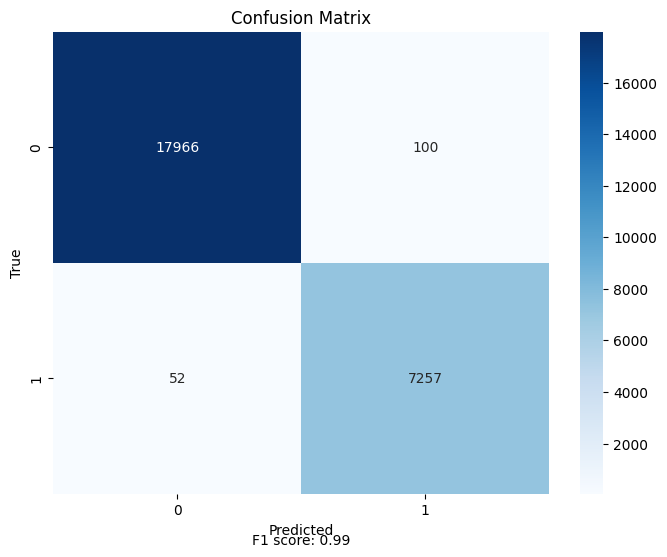

CSV file 'checkpoints/trial3/labels_tr.csv' has been created with the labels and headers.


In [41]:
model.eval()  # Ensure model is in evaluation mode
train_preds = []
train_targets = []

with torch.no_grad():
    for images, labels in tqdm(out_train_dataloader):
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        train_preds.extend(predicted.cpu().numpy())
        train_targets.extend(labels.cpu().numpy())

output_label = "checkpoints/trial3/labels_tr.csv"
label_data = list(zip(train_targets, train_preds))

# Draw conf mat routine
cm = confusion_matrix(train_targets, train_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['0', '1'], yticklabels=['0', '1'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
# Add F1 score as text to the plot
f1 = f1_score(train_targets, train_preds, average='macro')
plt.text(0.5, -0.1, f'F1 score: {f1:.2f}', horizontalalignment='center', verticalalignment='center', transform=plt.gca().transAxes)
plt.show()

with open(output_label, mode='w', newline='', encoding='utf-8') as file:
    writer = csv.writer(file)
    writer.writerow(['target', 'predicted'])
    writer.writerows(label_data)
print(f"CSV file '{output_label}' has been created with the labels and headers.")